In [1]:
import sail
import matplotlib as plt

In [2]:
#connect to computation virtual machine and obtain the virtual machine id, the id will be used as an location identifier when running jobs
vm=sail.connect("127.0.0.1", 7000)

In [3]:
#registering function nodes
fn_data_process = sail.registerfn("/home/jjj/playground/monofds/data_process_fn.py", 1, 5)[0];
fn_train = sail.registerfn("/home/jjj/playground/monofds/train_fn.py", 3, 1)[0];
fn_test = sail.registerfn("/home/jjj/playground/monofds/test_fn.py", 4, 5)[0];
fn_pred_process = sail.registerfn("/home/jjj/playground/monofds/pred_process_fn.py", 1, 1)[0];
fn_pred = sail.registerfn("/home/jjj/playground/monofds/pred_fn.py", 2, 1)[0];

In [4]:
sail.pushfn(vm, fn_data_process)
sail.pushfn(vm, fn_train)
sail.pushfn(vm, fn_test)
sail.pushfn(vm, fn_pred_process)
sail.pushfn(vm, fn_pred)

In [5]:
#data processing function node, reads in the data into secure computation envionment, taking in 1 input and generate 5 outputs
#input[1]: data table id
#output[1]: X(train set)
#output[2]: y(train set)
#output[3]: holdout_X(test set)
#output[4]: holdout_y(test set)
#output[5]: data frame of X(for shap)
jobid1 = sail.newguid()
sail.pushdata(vm, jobid1, fn_data_process, [0], "/home/jjj/playground")
sail.execjob(vm, fn_data_process, jobid1)

In [6]:
result = sail.pulldata(vm, jobid1, fn_data_process, "/home/jjj/playground")
X=result[0]
y=result[1]
holdout_X=result[2]
holdout_y=result[3]
df=result[4]

In [7]:
model_param = {'max_depth': 8, 'n_estimators': 100, 'colsample_bytree': 0.8, 'subsample': 0.8, 'nthread': 10, 'learning_rate': 0.1}

In [8]:
#training function node, taking in X, y and model parameters 3 inputs and generate 1 output
#input[1]: X(train set)
#input[2]: y(train set)
#input[3]: model parameter
#output[1]: model obtained from training
jobid2 = sail.newguid()
sail.pushdata(vm, jobid2, fn_train, [X, y, model_param], "/home/jjj/playground")
sail.execjob(vm, fn_train, jobid2)

In [9]:
result = sail.pulldata(vm, jobid2, fn_train, "/home/jjj/playground")
model = result[0]

In [10]:
#testing function node, taking in 4 inputs and generate 5 outputs
#input[1]: model
#input[2]: holdout_X(test set)
#input[3]: holdout_y(test set)
#input[4]: dataframe(for shap)
#output[1]: confusion matrix
#output[2]: erros
#output[3]: false negative rate
#output[4]: false positive rate
#output[5]: shap summary plot
jobid3 = sail.newguid()
sail.pushdata(vm, jobid3, fn_test, [model, holdout_X, holdout_y, df], "/home/jjj/playground")
sail.execjob(vm, fn_test, jobid3)

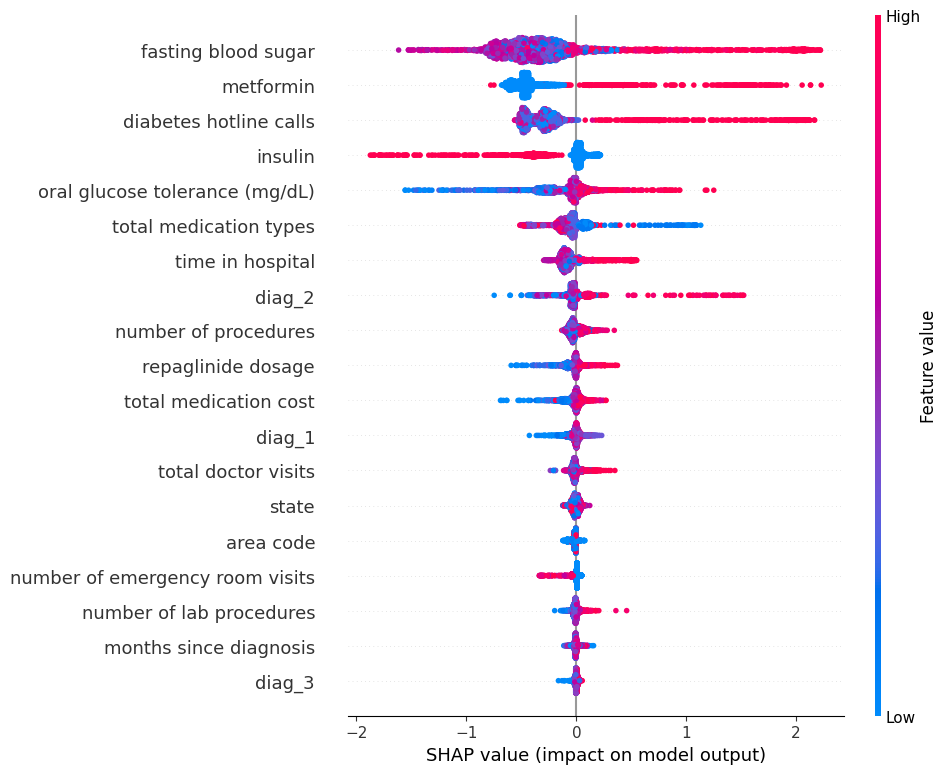

In [11]:
result = sail.pulldata(vm, jobid3, fn_test, "/home/jjj/playground")
conf = result[0]
errors = result[1]
fnr = result[2]
fpr = result[3]
fig = result[4]

In [12]:
conf

array([[625,  18],
       [ 31,  84]])

In [13]:
errors

0.06464379947229551

In [14]:
fnr

0.26956521739130435

In [15]:
fpr

0.027993779160186624

In [16]:
#prediction data preprocessing function node, taking in 1 input and generate 1 output
#input[1]: data table id
#output[1]: pred_X(predict set)
jobid4 = sail.newguid()
sail.pushdata(vm, jobid4, fn_pred_process, [1], "/home/jjj/playground")
sail.execjob(vm, fn_pred_process, jobid4)

In [17]:
result = sail.pulldata(vm, jobid4, fn_pred_process, "/home/jjj/playground")
pred_X = result[0]

In [18]:
#prediction function node, taking in 2 input and generate 1 output
#input[1]: model
#input[2]: pred_X(predict set)
#output[1]: prediction result
jobid5 = sail.newguid()
sail.pushdata(vm, jobid5, fn_pred, [model, pred_X], "/home/jjj/playground")
sail.execjob(vm, fn_pred, jobid5)

In [19]:
result = sail.pulldata(vm, jobid5, fn_pred, "/home/jjj/playground")
pred_y = result[0]

In [20]:
pred_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0.